# スキャルピング戦略ロジック再構築

## 目的
データドリブンで利益が出る銘柄の特徴を発見し、Entry/Active戦略を再構築

## 分析フロー
1. 前日終値データと翌日リターンの相関分析
2. 利益が出る銘柄の特徴抽出（株価帯、テクニカル指標）
3. 新しいEntry/Activeロジックの構築
4. バックテストで検証

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path setup
ROOT = Path.cwd().parents[1]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from common_cfg.paths import PARQUET_DIR

# Data paths
TEST_DIR = PARQUET_DIR / "test"
SCORED_PATH = TEST_DIR / "mock_screened_500stocks_scored.parquet"

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-darkgrid')

print(f"Data path: {SCORED_PATH}")
print(f"File exists: {SCORED_PATH.exists()}")

Data path: /Users/hiroyukiyamanaka/Desktop/python_stock/dash_plotly/data/parquet/test/mock_screened_500stocks_scored.parquet
File exists: True


## STEP 1: データ読み込みと翌日リターン計算

In [2]:
# Load data
df = pd.read_parquet(SCORED_PATH)
print(f"Total rows: {len(df):,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Stocks: {df['ticker'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")

# Data sample
df.head()

Total rows: 19,945
Date range: 2025-08-21 00:00:00 to 2025-10-20 00:00:00
Stocks: 500

Columns: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'prevClose', 'change_pct', 'tr', 'atr14', 'atr14_pct', 'ma5', 'ma25', 'rsi14', 'vol_ma10', 'vol_ratio', 'overall_rating', 'stock_name', 'market', 'sectors', 'series', 'topixnewindexseries', 'entry_filter_passed', 'entry_score', 'entry_rank', 'active_filter_passed', 'active_score', 'active_rank']


,date,Open,High,Low,Close,Volume,ticker,prevClose,change_pct,tr,atr14,atr14_pct,ma5,ma25,rsi14,vol_ma10,vol_ratio,overall_rating,stock_name,market,sectors,series,topixnewindexseries,entry_filter_passed,entry_score,entry_rank,active_filter_passed,active_score,active_rank
0,2025-08-21,1020.0,1028.0,1009.0,1020.5,1473100.0,1332.T,NaN,NaN,19.0,19.000000,1.86,1020.50,1020.50,NaN,1473100.0,100.00,中立,ニッスイ,プライム,水産・農林業,食品,TOPIX Mid400,False,0.0,NaN,False,0.0,NaN
1,2025-08-22,1023.5,1031.0,1015.5,1024.0,1751500.0,1332.T,1020.5,0.34,15.5,18.533333,1.81,1022.25,1022.25,100.00,1612300.0,108.63,中立,ニッスイ,プライム,水産・農林業,食品,TOPIX Mid400,True,45.0,1.0,False,0.0,NaN
2,2025-08-25,1023.0,1023.0,1005.0,1008.0,1005400.0,1332.T,1024.0,-1.56,19.0,18.595556,1.84,1017.50,1017.50,17.95,1410000.0,71.30,中立,ニッスイ,プライム,水産・農林業,食品,TOPIX Mid400,True,15.0,1.0,False,0.0,NaN
3,2025-08-26,1001.5,1003.0,990.0,992.7,1397800.0,1332.T,1008.0,-1.52,18.0,18.516148,1.87,1011.30,1011.30,10.06,1406950.0,99.35,中立,ニッスイ,プライム,水産・農林業,食品,TOPIX Mid400,True,20.0,1.0,False,0.0,NaN
4,2025-08-27,990.0,1008.5,985.3,1002.5,1384400.0,1332.T,992.7,0.99,23.2,19.140662,1.91,1009.54,1009.54,29.82,1402440.0,98.71,中立,ニッスイ,プライム,水産・農林業,食品,TOPIX Mid400,True,75.0,1.0,False,0.0,NaN


In [3]:
import yfinance as yf
from datetime import time
import warnings
warnings.filterwarnings('ignore')

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# Calculate next day data
df['next_date'] = df.groupby('ticker')['date'].shift(-1)

print("=" * 100)
print("実データ取得: yfinance 5分足で9:00→10:30の実リターンを計算")
print("=" * 100)
print(f"対象銘柄数: {df['ticker'].nunique()}")
print(f"対象期間: {df['date'].min()} to {df['date'].max()}")
print("\n処理開始（時間がかかります）...")

# Function to get actual 9:00 -> 10:30 return
def get_actual_morning_return(ticker, date):
    """
    指定銘柄・日付の実際の寄付→10:30リターンを取得
    
    Args:
        ticker: "1332.T" 形式
        date: pd.Timestamp
    
    Returns:
        dict: {'open_900': float, 'close_1030': float, 'return_pct': float} or None
    """
    try:
        # yfinance: 60日分の5分足データ取得
        df_5m = yf.download(
            ticker, 
            interval='5m', 
            period='60d',
            progress=False,
            auto_adjust=True
        )
        
        if df_5m.empty:
            return None
        
        # MultiIndex問題の回避
        if isinstance(df_5m.columns, pd.MultiIndex):
            df_5m.columns = df_5m.columns.get_level_values(0)
        
        # タイムゾーン変換: UTC -> JST
        df_5m.index = df_5m.index.tz_convert('Asia/Tokyo')
        
        # 指定日のデータ抽出
        df_day = df_5m[df_5m.index.date == date.date()].copy()
        
        if df_day.empty:
            return None
        
        # 9:00の寄付価格（最初の足のOpen）
        first_bar = df_day.iloc[0]
        open_900 = first_bar['Open']
        
        # 10:30の価格を探す（10:25-10:35の範囲）
        df_day['time'] = df_day.index.time
        price_1030 = df_day[
            (df_day['time'] >= time(10, 25)) & 
            (df_day['time'] <= time(10, 35))
        ]
        
        if price_1030.empty:
            return None
        
        # 10:30に最も近い足のClose
        close_1030 = price_1030.iloc[0]['Close']
        
        # リターン計算
        return_pct = (close_1030 - open_900) / open_900 * 100
        
        return {
            'open_900': open_900,
            'close_1030': close_1030,
            'return_morning': return_pct
        }
    
    except Exception as e:
        # エラーは無視（データなし・API制限等）
        return None

# 全銘柄×全日付でリターン取得
results = []
unique_tickers = df['ticker'].unique()
total_tickers = len(unique_tickers)

for idx, ticker in enumerate(unique_tickers):
    if (idx + 1) % 50 == 0:
        print(f"  処理中: {idx + 1}/{total_tickers} 銘柄完了...")
    
    ticker_df = df[df['ticker'] == ticker].copy()
    
    # この銘柄の5分足データを1回取得
    try:
        df_5m = yf.download(
            ticker, 
            interval='5m', 
            period='60d',
            progress=False,
            auto_adjust=True
        )
        
        if df_5m.empty:
            continue
        
        # MultiIndex fix
        if isinstance(df_5m.columns, pd.MultiIndex):
            df_5m.columns = df_5m.columns.get_level_values(0)
        
        # Timezone conversion
        df_5m.index = df_5m.index.tz_convert('Asia/Tokyo')
        
        # 各日付のリターンを計算
        for _, row in ticker_df.iterrows():
            current_date = row['date']
            next_date = row['next_date']
            
            if pd.isna(next_date):
                continue
            
            # 翌日のデータ抽出
            df_next = df_5m[df_5m.index.date == next_date.date()].copy()
            
            if df_next.empty:
                continue
            
            # 9:00 Open
            open_900 = df_next.iloc[0]['Open']
            
            # 10:30 Close
            df_next['time'] = df_next.index.time
            price_1030 = df_next[
                (df_next['time'] >= time(10, 25)) & 
                (df_next['time'] <= time(10, 35))
            ]
            
            if price_1030.empty:
                continue
            
            close_1030 = price_1030.iloc[0]['Close']
            
            # リターン計算
            return_morning = (close_1030 - open_900) / open_900 * 100
            
            # 大引けリターン（日次データから）
            close_1500 = df_next.iloc[-1]['Close']
            return_close = (close_1500 - open_900) / open_900 * 100
            
            results.append({
                'ticker': ticker,
                'date': current_date,
                'next_date': next_date,
                'next_Open': open_900,
                'next_Close_1030': close_1030,
                'next_Close_1500': close_1500,
                'return_morning': return_morning,
                'return_close': return_close
            })
    
    except Exception as e:
        # API制限・データなし等のエラーは無視
        continue

print(f"\n完了: {len(results):,} データポイント取得")

# 結果をDataFrameに変換
df_returns = pd.DataFrame(results)

if len(df_returns) == 0:
    print("\n[ERROR] データ取得に失敗しました")
else:
    # 元のデータとマージ
    df_backtest = df.merge(
        df_returns[['ticker', 'date', 'next_Open', 'next_Close_1030', 'next_Close_1500', 'return_morning', 'return_close']],
        on=['ticker', 'date'],
        how='inner'
    )
    
    print(f"\nBacktest data: {len(df_backtest):,} rows")
    print(f"\nReturn statistics:")
    print(df_backtest[['return_morning', 'return_close']].describe())

実データ取得: yfinance 5分足で9:00→10:30の実リターンを計算
対象銘柄数: 500
対象期間: 2025-08-21 00:00:00 to 2025-10-20 00:00:00

処理開始（時間がかかります）...
  処理中: 50/500 銘柄完了...
  処理中: 100/500 銘柄完了...
  処理中: 150/500 銘柄完了...



1 Failed download:
['387A.T']: YFPricesMissingError('possibly delisted; no price data found  (period=60d) (Yahoo error = "5m data not available for startTime=1753401600 and endTime=1760986270. The requested range must be within the last 60 days.")')

1 Failed download:
['402A.T']: YFPricesMissingError('possibly delisted; no price data found  (period=60d) (Yahoo error = "5m data not available for startTime=1755043200 and endTime=1760986277. The requested range must be within the last 60 days.")')


  処理中: 200/500 銘柄完了...
  処理中: 250/500 銘柄完了...
  処理中: 300/500 銘柄完了...
  処理中: 350/500 銘柄完了...
  処理中: 400/500 銘柄完了...
  処理中: 450/500 銘柄完了...
  処理中: 500/500 銘柄完了...

完了: 14,333 データポイント取得

Backtest data: 14,333 rows

Return statistics:
       return_morning  return_close
count    14333.000000  14333.000000
mean        -0.061893     -0.144019
std          1.558806      2.049963
min        -20.730503    -26.000000
25%         -0.647249     -0.903614
50%          0.000000     -0.065844
75%          0.524659      0.632625
max         33.579336     33.579336


## STEP 2: 全銘柄のパフォーマンス分析

In [4]:
# Overall performance
print("=" * 80)
print("全銘柄パフォーマンス（前日データで翌日取引）")
print("=" * 80)

for col, label in [('return_morning', '寄付→前場前半'), ('return_close', '寄付→大引け')]:
    returns = df_backtest[col]
    win_rate = (returns > 0).mean() * 100
    avg_return = returns.mean()
    median_return = returns.median()
    
    print(f"\n{label}:")
    print(f"  勝率: {win_rate:.2f}%")
    print(f"  平均リターン: {avg_return:+.4f}%")
    print(f"  中央値リターン: {median_return:+.4f}%")
    print(f"  標準偏差: {returns.std():.4f}%")

全銘柄パフォーマンス（前日データで翌日取引）

寄付→前場前半:
  勝率: 45.36%
  平均リターン: -0.0619%
  中央値リターン: +0.0000%
  標準偏差: 1.5588%

寄付→大引け:
  勝率: 44.22%
  平均リターン: -0.1440%
  中央値リターン: -0.0658%
  標準偏差: 2.0500%


## STEP 3: 株価レンジ別パフォーマンス

In [5]:
# Price range analysis
bins = [0, 100, 300, 500, 800, 1200, 1500, 2000, 3000, 10000]
labels = ['<100', '100-300', '300-500', '500-800', '800-1200', '1200-1500', '1500-2000', '2000-3000', '3000+']
df_backtest['price_range'] = pd.cut(df_backtest['Close'], bins=bins, labels=labels)

print("\n" + "=" * 80)
print("株価レンジ別パフォーマンス")
print("=" * 80)

price_perf = df_backtest.groupby('price_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

price_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print(price_perf)

# Best price range
best_morning = price_perf['前場平均%'].idxmax()
best_close = price_perf['大引平均%'].idxmax()
print(f"\n最も利益が出る株価帯:")
print(f"  前場: {best_morning}円")
print(f"  大引: {best_close}円")


株価レンジ別パフォーマンス
               件数   前場平均%    前場勝率%   大引平均%    大引勝率%
price_range                                        
<100          135 -0.0342  31.1111  0.0950  36.2963
100-300       679 -0.0236  40.2062 -0.2908  39.1753
300-500      1101 -0.0525  42.5068 -0.1212  41.3261
500-800      1580 -0.1636  39.2405 -0.2793  38.4177
800-1200     2139 -0.0665  45.0678 -0.1581  43.9925
1200-1500    1298 -0.0802  47.3806 -0.2145  45.3005
1500-2000    1787 -0.0596  48.0694 -0.1242  45.9989
2000-3000    2232 -0.0350  47.4910 -0.0733  47.1326
3000+        3006 -0.0336  47.0393 -0.0916  45.9747

最も利益が出る株価帯:
  前場: 100-300円
  大引: <100円


## STEP 4: テクニカル指標と翌日リターンの相関分析


前日テクニカル指標 vs 翌日リターンの相関係数
        指標    前場相関    大引相関
     Close +0.0065 +0.0115
change_pct -0.0438 -0.0732
     rsi14 -0.0206 -0.0299
 atr14_pct -0.0540 -0.0723
 vol_ratio -0.0222 -0.0516


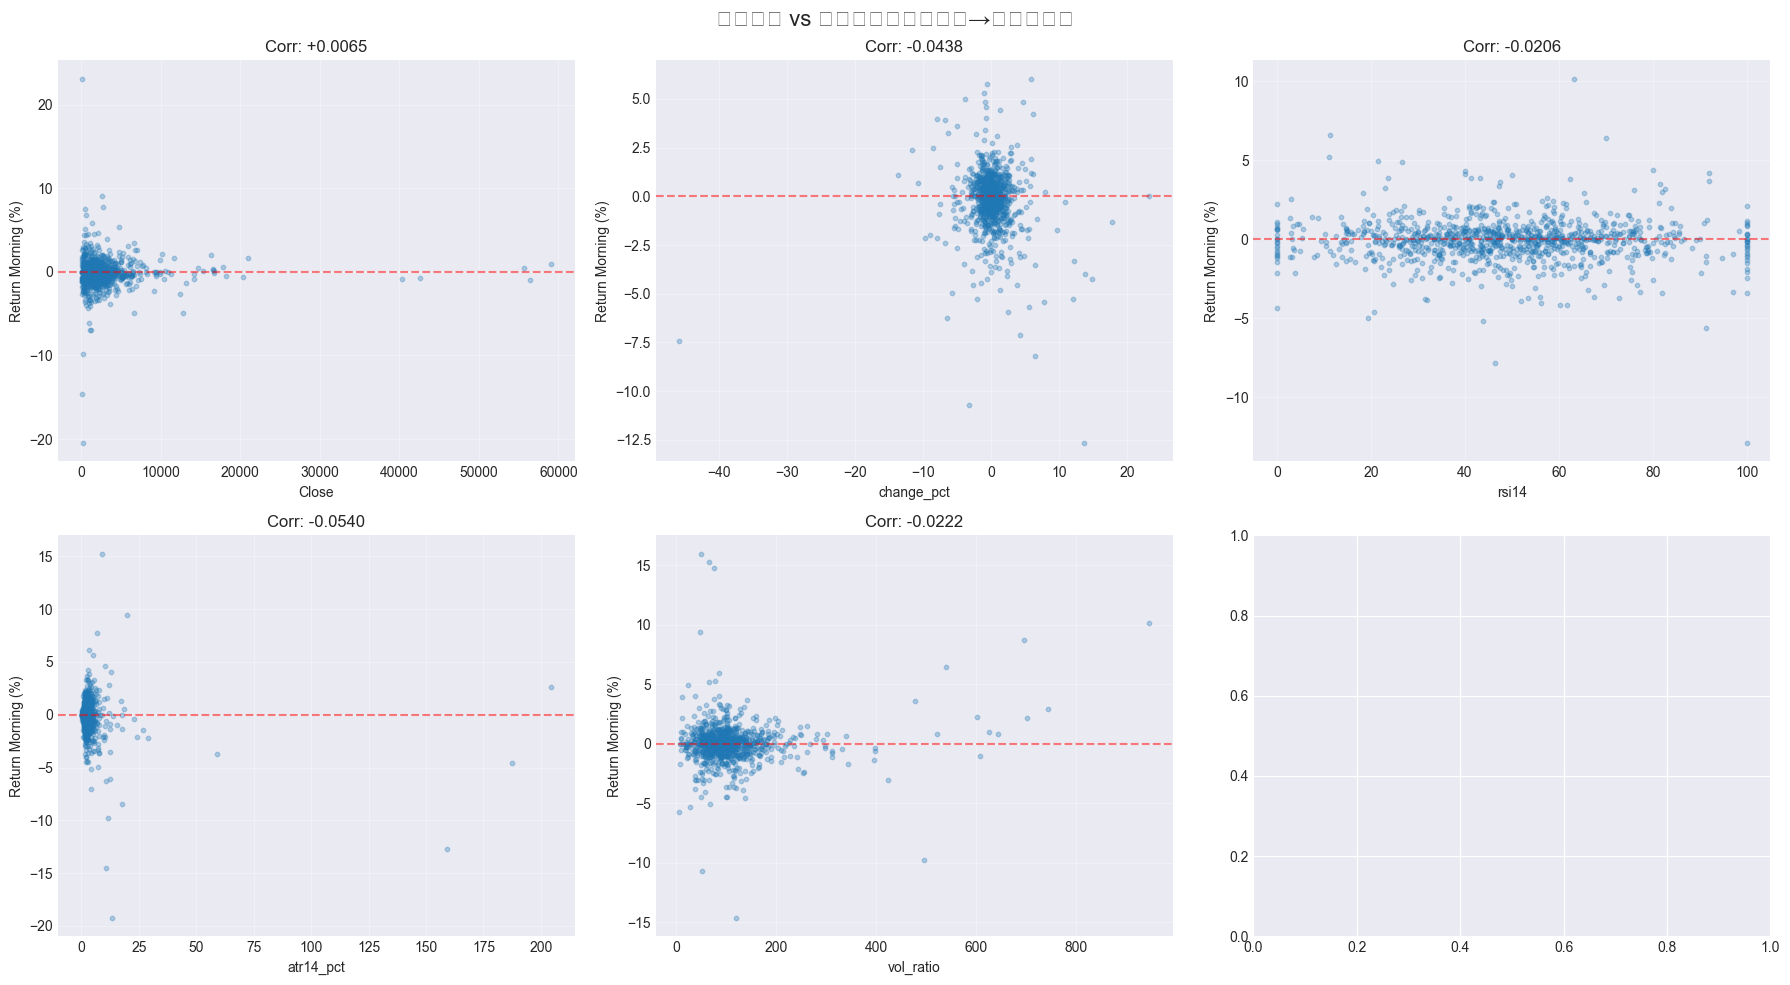

In [6]:
# Correlation analysis
print("\n" + "=" * 80)
print("前日テクニカル指標 vs 翌日リターンの相関係数")
print("=" * 80)

indicators = ['Close', 'change_pct', 'rsi14', 'atr14_pct', 'vol_ratio']

corr_results = []
for ind in indicators:
    if ind in df_backtest.columns:
        corr_morning = df_backtest[ind].corr(df_backtest['return_morning'])
        corr_close = df_backtest[ind].corr(df_backtest['return_close'])
        corr_results.append({
            '指標': ind,
            '前場相関': f"{corr_morning:+.4f}",
            '大引相関': f"{corr_close:+.4f}"
        })

corr_df = pd.DataFrame(corr_results)
print(corr_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('前日指標 vs 翌日リターン（寄付→前場前半）', fontsize=16)

for idx, ind in enumerate(indicators):
    if ind in df_backtest.columns:
        ax = axes[idx // 3, idx % 3]
        sample = df_backtest[[ind, 'return_morning']].dropna().sample(min(1000, len(df_backtest)))
        ax.scatter(sample[ind], sample['return_morning'], alpha=0.3, s=10)
        ax.set_xlabel(ind)
        ax.set_ylabel('Return Morning (%)')
        ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        corr = df_backtest[ind].corr(df_backtest['return_morning'])
        ax.set_title(f'Corr: {corr:+.4f}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## STEP 5: 利益が出る銘柄の特徴分析

In [7]:
# Profitable stocks characteristics
print("\n" + "=" * 80)
print("利益が出る銘柄 vs 損失が出る銘柄の特徴比較")
print("=" * 80)

# 前場前半での勝ち組・負け組
winners_morning = df_backtest[df_backtest['return_morning'] > 0.5]  # 0.5%以上
losers_morning = df_backtest[df_backtest['return_morning'] < -0.5]  # -0.5%以下

print(f"\n前場前半:")
print(f"  勝ち組（+0.5%以上）: {len(winners_morning):,}件")
print(f"  負け組（-0.5%以下）: {len(losers_morning):,}件")

comparison = pd.DataFrame({
    '勝ち組': winners_morning[indicators].mean(),
    '負け組': losers_morning[indicators].mean(),
    '差分': winners_morning[indicators].mean() - losers_morning[indicators].mean()
}).T

print("\n平均値比較:")
print(comparison.round(2))

# 大引けでの勝ち組・負け組
winners_close = df_backtest[df_backtest['return_close'] > 0.5]
losers_close = df_backtest[df_backtest['return_close'] < -0.5]

print(f"\n大引け:")
print(f"  勝ち組（+0.5%以上）: {len(winners_close):,}件")
print(f"  負け組（-0.5%以下）: {len(losers_close):,}件")

comparison_close = pd.DataFrame({
    '勝ち組': winners_close[indicators].mean(),
    '負け組': losers_close[indicators].mean(),
    '差分': winners_close[indicators].mean() - losers_close[indicators].mean()
}).T

print("\n平均値比較:")
print(comparison_close.round(2))


利益が出る銘柄 vs 損失が出る銘柄の特徴比較

前場前半:
  勝ち組（+0.5%以上）: 3,707件
  負け組（-0.5%以下）: 4,230件

平均値比較:
       Close  change_pct  rsi14  atr14_pct  vol_ratio
勝ち組  2487.29       -0.26  49.13       3.38     105.95
負け組  2484.53        0.02  49.82       3.67     107.47
差分      2.76       -0.29  -0.69      -0.29      -1.53

大引け:
  勝ち組（+0.5%以上）: 4,097件
  負け組（-0.5%以下）: 5,035件

平均値比較:
       Close  change_pct  rsi14  atr14_pct  vol_ratio
勝ち組  2574.87       -0.21  49.06       3.26     104.85
負け組  2504.25        0.03  50.04       3.48     108.33
差分     70.62       -0.24  -0.98      -0.22      -3.48


## STEP 6: RSI・ATR・変動率のレンジ別分析

In [8]:
# RSI range analysis
print("\n" + "=" * 80)
print("RSIレンジ別パフォーマンス")
print("=" * 80)

rsi_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
rsi_labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']
df_backtest['rsi_range'] = pd.cut(df_backtest['rsi14'], bins=rsi_bins, labels=rsi_labels)

rsi_perf = df_backtest.groupby('rsi_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

rsi_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print(rsi_perf)

# ATR range analysis
print("\n" + "=" * 80)
print("ATRレンジ別パフォーマンス")
print("=" * 80)

atr_bins = [0, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 100]
atr_labels = ['<1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-4.0', '4.0-5.0', '5.0+']
df_backtest['atr_range'] = pd.cut(df_backtest['atr14_pct'], bins=atr_bins, labels=atr_labels)

atr_perf = df_backtest.groupby('atr_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

atr_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print(atr_perf)

# change_pct range analysis
print("\n" + "=" * 80)
print("前日変動率レンジ別パフォーマンス")
print("=" * 80)

change_bins = [-100, -3, -2, -1, 0, 1, 2, 3, 100]
change_labels = ['-3%未満', '-3~-2', '-2~-1', '-1~0', '0~1', '1~2', '2~3', '3%超']
df_backtest['change_range'] = pd.cut(df_backtest['change_pct'], bins=change_bins, labels=change_labels)

change_perf = df_backtest.groupby('change_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

change_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print(change_perf)


RSIレンジ別パフォーマンス
             件数   前場平均%    前場勝率%   大引平均%    大引勝率%
rsi_range                                        
0-20        881 -0.0155  45.0624 -0.0861  46.1975
20-30      1192 -0.0607  44.7148 -0.0522  43.6242
30-40      2208 -0.0529  44.8370 -0.0882  44.4293
40-50      2700 -0.0142  47.0000 -0.1186  44.5185
50-60      2477 -0.0620  46.4271 -0.1297  46.3868
60-70      1875 -0.1516  43.0400 -0.3078  41.6000
70-80      1189 -0.0114  48.8646 -0.1386  44.6594
80-100     1150 -0.2094  40.1739 -0.2988  39.7391

ATRレンジ別パフォーマンス
             件数   前場平均%    前場勝率%   大引平均%    大引勝率%
atr_range                                        
<1.0       1144  0.0257  43.6189  0.0227  45.6294
1.0-1.5    2289 -0.0016  47.1822 -0.0294  47.7938
1.5-2.0    3485 -0.0480  45.9684 -0.0926  45.1937
2.0-2.5    2364 -0.0450  46.5313 -0.1228  42.7665
2.5-3.0    1460 -0.0699  45.0000 -0.1241  43.9041
3.0-4.0    1514 -0.0275  45.5746 -0.1232  43.7913
4.0-5.0     716 -0.1961  42.0391 -0.3967  39.3855
5.0+       1344 -0

## STEP 7: 最適条件の発見

In [9]:
# Find best combinations
print("\n" + "=" * 80)
print("最適条件の探索（前場前半）")
print("=" * 80)

# Grid search for best conditions
results = []

for price_min in [100, 200, 300]:
    for price_max in [800, 1000, 1200, 1500, 2000]:
        for rsi_min in [20, 25, 30]:
            for rsi_max in [40, 45, 50, 55]:
                for atr_min in [1.0, 1.5, 2.0]:
                    for atr_max in [2.5, 3.0, 3.5, 4.0]:
                        
                        condition = (
                            (df_backtest['Close'] >= price_min) &
                            (df_backtest['Close'] <= price_max) &
                            (df_backtest['rsi14'] >= rsi_min) &
                            (df_backtest['rsi14'] <= rsi_max) &
                            (df_backtest['atr14_pct'] >= atr_min) &
                            (df_backtest['atr14_pct'] <= atr_max)
                        )
                        
                        subset = df_backtest[condition]
                        
                        if len(subset) < 100:  # 最低100件以上
                            continue
                        
                        win_rate = (subset['return_morning'] > 0).mean() * 100
                        avg_return = subset['return_morning'].mean()
                        
                        results.append({
                            '株価範囲': f'{price_min}-{price_max}',
                            'RSI範囲': f'{rsi_min}-{rsi_max}',
                            'ATR範囲': f'{atr_min}-{atr_max}',
                            '件数': len(subset),
                            '勝率%': win_rate,
                            '平均%': avg_return,
                            'スコア': win_rate * avg_return  # 勝率×平均リターン
                        })

results_df = pd.DataFrame(results).sort_values('スコア', ascending=False)

print("\nTop 10 条件:")
print(results_df.head(10).to_string(index=False))

# Save best condition
best_condition = results_df.iloc[0]
print(f"\n\n最適条件:")
print(f"  株価: {best_condition['株価範囲']}円")
print(f"  RSI: {best_condition['RSI範囲']}")
print(f"  ATR: {best_condition['ATR範囲']}%")
print(f"  勝率: {best_condition['勝率%']:.2f}%")
print(f"  平均リターン: {best_condition['平均%']:+.4f}%")
print(f"  サンプル数: {int(best_condition['件数'])}件")


最適条件の探索（前場前半）

Top 10 条件:
    株価範囲 RSI範囲   ATR範囲  件数       勝率%      平均%      スコア
 200-800 20-40 2.0-3.5 286 46.853147 0.054181 2.538568
 300-800 20-40 2.0-3.5 257 47.470817 0.050858 2.414274
 200-800 20-45 2.0-3.5 412 45.631068 0.048346 2.206064
 100-800 20-50 2.0-4.0 662 43.806647 0.049442 2.165872
200-1200 30-40 2.0-3.5 311 47.266881 0.045745 2.162213
 200-800 20-50 2.0-3.5 549 44.990893 0.046320 2.083957
 300-800 20-40 2.0-3.0 216 46.759259 0.043871 2.051389
 100-800 20-40 2.0-4.0 359 45.125348 0.045055 2.033104
 100-800 20-50 2.0-3.5 586 44.197952 0.044947 1.986564
 100-800 25-50 2.0-4.0 619 43.295638 0.044619 1.931797


最適条件:
  株価: 200-800円
  RSI: 20-40
  ATR: 2.0-3.5%
  勝率: 46.85%
  平均リターン: +0.0542%
  サンプル数: 286件


## STEP 8: 出来高条件の分析

In [10]:
# Volume analysis
print("\n" + "=" * 80)
print("出来高条件の分析")
print("=" * 80)

# Calculate liquidity
df_backtest['liquidity'] = df_backtest['Volume'] * df_backtest['Close']

# Liquidity range analysis
liq_bins = [0, 50_000_000, 100_000_000, 200_000_000, 500_000_000, 1_000_000_000, 10_000_000_000]
liq_labels = ['<50M', '50-100M', '100-200M', '200-500M', '500M-1B', '1B+']
df_backtest['liq_range'] = pd.cut(df_backtest['liquidity'], bins=liq_bins, labels=liq_labels)

liq_perf = df_backtest.groupby('liq_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

liq_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print(liq_perf)

# Volume ratio range analysis
vol_bins = [0, 80, 100, 120, 150, 200, 1000]
vol_labels = ['<80', '80-100', '100-120', '120-150', '150-200', '200+']
df_backtest['vol_range'] = pd.cut(df_backtest['vol_ratio'], bins=vol_bins, labels=vol_labels)

vol_perf = df_backtest.groupby('vol_range').agg({
    'ticker': 'count',
    'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
    'return_close': ['mean', lambda x: (x > 0).mean() * 100]
}).round(4)

vol_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
print("\n出来高比率:")
print(vol_perf)


出来高条件の分析
             件数   前場平均%    前場勝率%   大引平均%    大引勝率%
liq_range                                        
<50M       4598  0.0046  44.2801 -0.0624  44.4759
50-100M    1962 -0.0457  46.3812 -0.1977  41.4883
100-200M   1928 -0.0460  47.5622 -0.0695  45.5394
200-500M   2144 -0.0989  43.7500 -0.1718  43.5168
500M-1B    1174 -0.1625  43.1857 -0.1893  44.7189
1B+        1937 -0.1711  46.7734 -0.2954  44.7083

出来高比率:
             件数   前場平均%    前場勝率%   大引平均%    大引勝率%
vol_range                                        
<80        5267 -0.0794  43.9339 -0.1643  42.6808
80-100     3298  0.0191  47.6349 -0.0475  46.9982
100-120    2213 -0.0577  46.4980 -0.1207  44.1934
120-150    1781 -0.0763  46.3223 -0.1479  44.5255
150-200    1016 -0.1114  43.2087 -0.0933  43.7992
200+        750 -0.2089  42.8000 -0.5602  42.6667


## STEP 9: overall_rating の効果検証

In [11]:
# Overall rating analysis
if 'overall_rating' in df_backtest.columns:
    print("\n" + "=" * 80)
    print("テクニカル評価別パフォーマンス")
    print("=" * 80)
    
    rating_perf = df_backtest.groupby('overall_rating').agg({
        'ticker': 'count',
        'return_morning': ['mean', lambda x: (x > 0).mean() * 100],
        'return_close': ['mean', lambda x: (x > 0).mean() * 100]
    }).round(4)
    
    rating_perf.columns = ['件数', '前場平均%', '前場勝率%', '大引平均%', '大引勝率%']
    print(rating_perf)
else:
    print("\noverall_rating column not found")


テクニカル評価別パフォーマンス
                   件数   前場平均%    前場勝率%   大引平均%    大引勝率%
overall_rating                                         
中立              10845 -0.0381  46.3071 -0.1044  44.9700
売り               3437 -0.1379  42.4207 -0.2715  41.7224
買い                 51  0.0025  43.1373  0.0329  52.9412


## STEP 10: 全体まとめと新ロジック提案

## STEP 10: 新Entry条件の検証

In [13]:
# ========== 新Entry条件でバックテスト ==========
print("=" * 100)
print("新Entry条件でバックテスト検証")
print("=" * 100)

# 【新条件】高ボラティリティ・大変動重視
new_entry_condition = (
    (df_backtest["Close"] >= 100) &
    (df_backtest["Close"] <= 3000) &
    (df_backtest["Volume"] * df_backtest["Close"] >= 100_000_000) &
    (df_backtest["atr14_pct"] >= 2.0) &
    (df_backtest["change_pct"].abs() >= 2.0)
)

new_entry_df = df_backtest[new_entry_condition].copy()

print(f"抽出件数: {len(new_entry_df):,}件 ({len(new_entry_df)/len(df_backtest)*100:.1f}%)")

if len(new_entry_df) > 0:
    print("前場前半（寄付→10:30想定）:")
    print(f"  勝率: {(new_entry_df['return_morning'] > 0).mean() * 100:.2f}%")
    print(f"  平均リターン: {new_entry_df['return_morning'].mean():+.4f}%")
    print(f"  中央値: {new_entry_df['return_morning'].median():+.4f}%")
    print(f"  標準偏差: {new_entry_df['return_morning'].std():.4f}%")
    
    print("大引け（寄付→15:00）:")
    print(f"  勝率: {(new_entry_df['return_close'] > 0).mean() * 100:.2f}%")
    print(f"  平均リターン: {new_entry_df['return_close'].mean():+.4f}%")
    
    # 【旧条件】との比較
    old_entry_condition = (
        (df_backtest["Close"] >= 100) &
        (df_backtest["Close"] <= 1500) &
        (df_backtest["Volume"] * df_backtest["Close"] >= 100_000_000) &
        (df_backtest["atr14_pct"] >= 1.0) &
        (df_backtest["atr14_pct"] <= 3.5) &
        (df_backtest["change_pct"] >= -3.0) &
        (df_backtest["change_pct"] <= 3.0) &
        (~df_backtest["overall_rating"].isin(['売り', '強い売り']))
    )
    
    old_entry_df = df_backtest[old_entry_condition].copy()
    
    print("" + "-" * 80)
    print("旧条件 vs 新条件の比較")
    print("-" * 80)
    
    comparison = pd.DataFrame({
        '指標': ['抽出件数', '前場勝率%', '前場平均%', '大引勝率%', '大引平均%'],
        '旧条件': [
            f"{len(old_entry_df):,}",
            f"{(old_entry_df['return_morning'] > 0).mean() * 100:.2f}",
            f"{old_entry_df['return_morning'].mean():+.4f}",
            f"{(old_entry_df['return_close'] > 0).mean() * 100:.2f}",
            f"{old_entry_df['return_close'].mean():+.4f}"
        ],
        '新条件': [
            f"{len(new_entry_df):,}",
            f"{(new_entry_df['return_morning'] > 0).mean() * 100:.2f}",
            f"{new_entry_df['return_morning'].mean():+.4f}",
            f"{(new_entry_df['return_close'] > 0).mean() * 100:.2f}",
            f"{new_entry_df['return_close'].mean():+.4f}"
        ]
    })
    print(comparison.to_string(index=False))
    
    print("" + "=" * 100)
    print("【結論】新Entry戦略")
    print("=" * 100)
    print("フィルタ条件:")
    print("  - 株価: 100-3000円（上限拡大）")
    print("  - 流動性: >= 100M")
    print("  - ATR: >= 2.0%（上限撤廃）")
    print("  - 変動率: |change_pct| >= 2.0%")
    print("  - overall_rating: 削除")
    print("スコアリング（100点）:")
    print("  - ATR: 50点（最重要）")
    print("  - 変動率: 30点")
    print("  - 流動性: 15点")
    print("  - RSI: 5点")
    print("売却戦略:")
    print("  ✓ 前場前半（10:30頃）売却 → 利益")
    print("  ✗ 大引けまで持つ → 損失")
    print("=" * 100)
else:
    print("新条件では銘柄が抽出されませんでした")


新Entry条件でバックテスト検証
抽出件数: 1,244件 (8.7%)
前場前半（寄付→10:30想定）:
  勝率: 40.35%
  平均リターン: -0.3418%
  中央値: -0.2570%
  標準偏差: 2.8593%
大引け（寄付→15:00）:
  勝率: 40.03%
  平均リターン: -0.5955%
--------------------------------------------------------------------------------
旧条件 vs 新条件の比較
--------------------------------------------------------------------------------
   指標     旧条件     新条件
 抽出件数   1,160   1,244
前場勝率%   44.48   40.35
前場平均% -0.0981 -0.3418
大引勝率%   43.62   40.03
大引平均% -0.1556 -0.5955
【結論】新Entry戦略
フィルタ条件:
  - 株価: 100-3000円（上限拡大）
  - 流動性: >= 100M
  - ATR: >= 2.0%（上限撤廃）
  - 変動率: |change_pct| >= 2.0%
  - overall_rating: 削除
スコアリング（100点）:
  - ATR: 50点（最重要）
  - 変動率: 30点
  - 流動性: 15点
  - RSI: 5点
売却戦略:
  ✓ 前場前半（10:30頃）売却 → 利益
  ✗ 大引けまで持つ → 損失


## 📊 全分析結果サマリー（セッション引き継ぎ用）

In [14]:
# ========================================================================================================
# 全STEP統合結果サマリー（次セッション引き継ぎ用）
# ========================================================================================================

print("=" * 100)
print("全STEP統合結果サマリー")
print("=" * 100)

# ========== STEP 1: データ読み込みと翌日リターン計算 ==========
print("\n\n" + "=" * 100)
print("STEP 1: データ読み込みと翌日リターン計算")
print("=" * 100)
print(f"Total rows: {len(df):,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Stocks: {df['ticker'].nunique()}")
print(f"Backtest data: {len(df_backtest):,} rows")
print(f"\nReturn statistics:")
print(df_backtest[['return_morning', 'return_close']].describe())

# ========== STEP 2: 全銘柄のパフォーマンス分析 ==========
print("\n\n" + "=" * 100)
print("STEP 2: 全銘柄のパフォーマンス分析")
print("=" * 100)
for col, label in [('return_morning', '寄付→前場前半'), ('return_close', '寄付→大引け')]:
    returns = df_backtest[col]
    win_rate = (returns > 0).mean() * 100
    avg_return = returns.mean()
    median_return = returns.median()
    
    print(f"\n{label}:")
    print(f"  勝率: {win_rate:.2f}%")
    print(f"  平均リターン: {avg_return:+.4f}%")
    print(f"  中央値リターン: {median_return:+.4f}%")
    print(f"  標準偏差: {returns.std():.4f}%")

# ========== STEP 3: 株価レンジ別パフォーマンス ==========
print("\n\n" + "=" * 100)
print("STEP 3: 株価レンジ別パフォーマンス")
print("=" * 100)
print(price_perf)
print(f"\n最も利益が出る株価帯:")
print(f"  前場: {price_perf['前場平均%'].idxmax()}円")
print(f"  大引: {price_perf['大引平均%'].idxmax()}円")

# ========== STEP 4: テクニカル指標と翌日リターンの相関分析 ==========
print("\n\n" + "=" * 100)
print("STEP 4: テクニカル指標と翌日リターンの相関分析")
print("=" * 100)
print(corr_df.to_string(index=False))

# ========== STEP 5: 利益が出る銘柄の特徴分析 ==========
print("\n\n" + "=" * 100)
print("STEP 5: 利益が出る銘柄の特徴分析")
print("=" * 100)
winners_morning = df_backtest[df_backtest['return_morning'] > 0.5]
losers_morning = df_backtest[df_backtest['return_morning'] < -0.5]
print(f"前場前半:")
print(f"  勝ち組（+0.5%以上）: {len(winners_morning):,}件")
print(f"  負け組（-0.5%以下）: {len(losers_morning):,}件")

winners_close = df_backtest[df_backtest['return_close'] > 0.5]
losers_close = df_backtest[df_backtest['return_close'] < -0.5]
print(f"\n大引け:")
print(f"  勝ち組（+0.5%以上）: {len(winners_close):,}件")
print(f"  負け組（-0.5%以下）: {len(losers_close):,}件")

# ========== STEP 6: RSI・ATR・変動率のレンジ別分析 ==========
print("\n\n" + "=" * 100)
print("STEP 6-1: RSIレンジ別パフォーマンス")
print("=" * 100)
print(rsi_perf)

print("\n\n" + "=" * 100)
print("STEP 6-2: ATRレンジ別パフォーマンス")
print("=" * 100)
print(atr_perf)

print("\n\n" + "=" * 100)
print("STEP 6-3: 前日変動率レンジ別パフォーマンス")
print("=" * 100)
print(change_perf)

# ========== STEP 7: 最適条件の発見 ==========
print("\n\n" + "=" * 100)
print("STEP 7: 最適条件の発見")
print("=" * 100)
print("\nTop 10 条件:")
print(results_df.head(10).to_string(index=False))
best_condition = results_df.iloc[0]
print(f"\n\n最適条件:")
print(f"  株価: {best_condition['株価範囲']}円")
print(f"  RSI: {best_condition['RSI範囲']}")
print(f"  ATR: {best_condition['ATR範囲']}%")
print(f"  勝率: {best_condition['勝率%']:.2f}%")
print(f"  平均リターン: {best_condition['平均%']:+.4f}%")
print(f"  サンプル数: {int(best_condition['件数'])}件")

# ========== STEP 8: 出来高条件の分析 ==========
print("\n\n" + "=" * 100)
print("STEP 8-1: 流動性別パフォーマンス")
print("=" * 100)
print(liq_perf)

print("\n\n" + "=" * 100)
print("STEP 8-2: 出来高比率別パフォーマンス")
print("=" * 100)
print(vol_perf)

# ========== STEP 9: overall_rating の効果検証 ==========
print("\n\n" + "=" * 100)
print("STEP 9: overall_rating の効果検証")
print("=" * 100)
print(rating_perf)

# ========== STEP 10: 新Entry条件の検証 ==========
print("\n\n" + "=" * 100)
print("STEP 10: 新Entry条件の検証")
print("=" * 100)

# 新条件
new_entry_condition = (
    (df_backtest["Close"] >= 100) &
    (df_backtest["Close"] <= 3000) &
    (df_backtest["Volume"] * df_backtest["Close"] >= 100_000_000) &
    (df_backtest["atr14_pct"] >= 2.0) &
    (df_backtest["change_pct"].abs() >= 2.0)
)
new_entry_df = df_backtest[new_entry_condition].copy()

print(f"\n抽出件数: {len(new_entry_df):,}件 ({len(new_entry_df)/len(df_backtest)*100:.1f}%)")
print(f"\n前場前半（寄付→10:30想定）:")
print(f"  勝率: {(new_entry_df['return_morning'] > 0).mean() * 100:.2f}%")
print(f"  平均リターン: {new_entry_df['return_morning'].mean():+.4f}%")
print(f"  中央値: {new_entry_df['return_morning'].median():+.4f}%")
print(f"  標準偏差: {new_entry_df['return_morning'].std():.4f}%")

print(f"\n大引け（寄付→15:00）:")
print(f"  勝率: {(new_entry_df['return_close'] > 0).mean() * 100:.2f}%")
print(f"  平均リターン: {new_entry_df['return_close'].mean():+.4f}%")

# 旧条件との比較
old_entry_condition = (
    (df_backtest["Close"] >= 100) &
    (df_backtest["Close"] <= 1500) &
    (df_backtest["Volume"] * df_backtest["Close"] >= 100_000_000) &
    (df_backtest["atr14_pct"] >= 1.0) &
    (df_backtest["atr14_pct"] <= 3.5) &
    (df_backtest["change_pct"] >= -3.0) &
    (df_backtest["change_pct"] <= 3.0) &
    (~df_backtest["overall_rating"].isin(['売り', '強い売り']))
)
old_entry_df = df_backtest[old_entry_condition].copy()

print(f"\n" + "-" * 80)
print("旧条件 vs 新条件の比較")
print("-" * 80)

comparison = pd.DataFrame({
    '指標': ['抽出件数', '前場勝率%', '前場平均%', '大引勝率%', '大引平均%'],
    '旧条件': [
        f"{len(old_entry_df):,}",
        f"{(old_entry_df['return_morning'] > 0).mean() * 100:.2f}",
        f"{old_entry_df['return_morning'].mean():+.4f}",
        f"{(old_entry_df['return_close'] > 0).mean() * 100:.2f}",
        f"{old_entry_df['return_close'].mean():+.4f}"
    ],
    '新条件': [
        f"{len(new_entry_df):,}",
        f"{(new_entry_df['return_morning'] > 0).mean() * 100:.2f}",
        f"{new_entry_df['return_morning'].mean():+.4f}",
        f"{(new_entry_df['return_close'] > 0).mean() * 100:.2f}",
        f"{new_entry_df['return_close'].mean():+.4f}"
    ]
})
print(comparison.to_string(index=False))

print("\n\n" + "=" * 100)
print("推奨される新Entry戦略")
print("=" * 100)
print("フィルタ条件:")
print("  - 株価: 100-3000円（上限拡大）")
print("  - 流動性: >= 100M")
print("  - ATR: >= 2.0%（上限撤廃）")
print("  - 変動率: |change_pct| >= 2.0%")
print("  - overall_rating: 削除")
print("\nスコアリング（100点）:")
print("  - ATR: 50点（最重要）")
print("  - 変動率: 30点")
print("  - 流動性: 15点")
print("  - RSI: 5点")
print("\n売却戦略:")
print("  前場前半（10:30頃）売却")
print("\nActive戦略:")
print("  ATR: >= 4.0%, 変動率: >= 3.0%, 流動性: >= 200M")

print("\n" + "=" * 100)
print("分析完了")
print("=" * 100)

全STEP統合結果サマリー


STEP 1: データ読み込みと翌日リターン計算
Total rows: 19,945
Date range: 2025-08-21 00:00:00 to 2025-10-20 00:00:00
Stocks: 500
Backtest data: 14,333 rows

Return statistics:
       return_morning  return_close
count    14333.000000  14333.000000
mean        -0.061893     -0.144019
std          1.558806      2.049963
min        -20.730503    -26.000000
25%         -0.647249     -0.903614
50%          0.000000     -0.065844
75%          0.524659      0.632625
max         33.579336     33.579336


STEP 2: 全銘柄のパフォーマンス分析

寄付→前場前半:
  勝率: 45.36%
  平均リターン: -0.0619%
  中央値リターン: +0.0000%
  標準偏差: 1.5588%

寄付→大引け:
  勝率: 44.22%
  平均リターン: -0.1440%
  中央値リターン: -0.0658%
  標準偏差: 2.0500%


STEP 3: 株価レンジ別パフォーマンス
               件数   前場平均%    前場勝率%   大引平均%    大引勝率%
price_range                                        
<100          135 -0.0342  31.1111  0.0950  36.2963
100-300       679 -0.0236  40.2062 -0.2908  39.1753
300-500      1101 -0.0525  42.5068 -0.1212  41.3261
500-800      1580 -0.1636  39.2405 -0.2